### Planner Notebook

This notebook is my way of developing and testing the KML loading + route-finding, until it works well enough to write into a full program.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



File has 89658 elements and 89530 linestrings, leaving 128 other elements (I believe only region polygons)


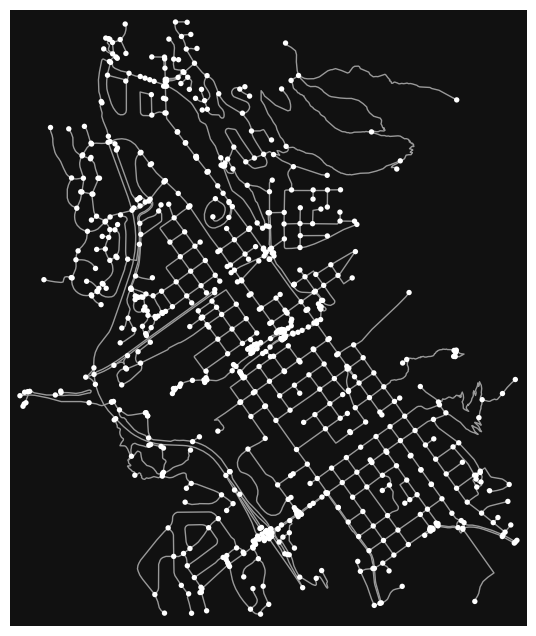

In [6]:
%run load_geo.ipynb

In [7]:
import numpy as np
import networkx as nx

# Inform pylint of some of the variables loaded from load_geo.ipynb
graph: nx.MultiGraph = graph
start_node: int = start_node
goal_node: int = goal_node

In [8]:
import aco_algo.ACOSettings
import aco_algo.AntColony
import aco_algo.Ant
from importlib import reload
reload(aco_algo.Ant)
reload(aco_algo.AntColony)
reload(aco_algo.ACOSettings)

settings = aco_algo.ACOSettings.ACOSettings(
    start_node=start_node,
    goal_nodes=[goal_node],
    num_ants=10,
    evaporation=0.5,
    target_length=1300,
    pheromone_weight=0.5,
    heuristic_weight=0.5,

    directional_coeff=0.5,
    directional_choosiness=2,
    traveled_discount=0.9,
    deadendness_coeff=0.5,
    finish_boost=0.5,
    gohome_boost=1.0,
)


In [9]:
colony = aco_algo.AntColony.AntColony(graph, settings)
col_graph = colony.network_graph
colony.run_iteration()

Ant Colony Algo Init
Precomputing betweenness centrality
Precomputing shortest paths to goals
Ant Colony Algo Init Done
Ant Colony Algo Run
Ant Colony Algo Run Done


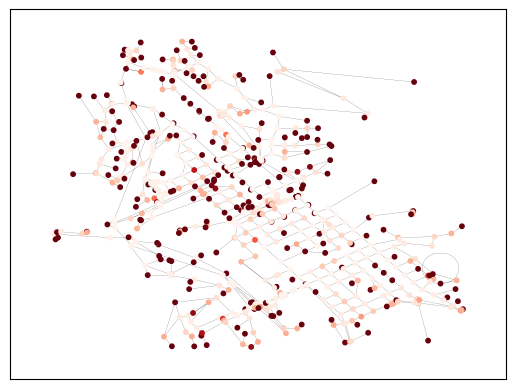

In [10]:
# Experiment with betweenness centrality
pos_dict = {key: attr["proj_pos"] for key, attr in col_graph.nodes(data=True)}
betweenness = np.array(list(nx.get_node_attributes(col_graph, "betweenness_centrality").values()))
# node_colors = [1 if math.cos(color*math.pi/2)**4 else 0 for color in node_colors]
deadendness = 1/(1+1000*betweenness)
# node_colors = very_dead_end_ratio * very_dead_end_bonus + (1-very_dead_end_ratio) * deadendness
node_colors = deadendness
nx.draw_networkx(col_graph, pos=pos_dict, node_color=node_colors, cmap="Reds", with_labels=False, node_size=10, width=0.1, edge_color="black")

In [11]:
from timeit import timeit
reload(aco_algo.Ant)

settings.directional_coeff = 10000
settings.directional_choosiness = 20
settings.traveled_discount = 0
settings.gohome_boost = 0

ant = aco_algo.Ant.Ant(col_graph, settings)
runtime = timeit(lambda: ant.desireabilities(col_graph.edges(start_node, data=True)), number=1000)
print(f"Desireability Runtime: {runtime}")

lengths = []
for i in range(1000):
    route, traveled_length = ant.run()
    lengths.append(traveled_length)
    # print(f"Num Nodes: {len(route)}, length: {traveled_length}")
print(f"Average length: {sum(lengths)/len(lengths)} (min: {min(lengths)}, max: {max(lengths)}) (target: {settings.target_length})")
print(f"Stddev: {np.std(lengths)}")

Desireability Runtime: 0.10480299999471754
Average length: 1969.8372352934102 (min: 1316.6706058018058, max: 6684.343720511868) (target: 1300)
Stddev: 593.404969848467


In [12]:
edges = col_graph.edges(5669, data=True)
desires = ant.desireabilities(edges)
list(zip(edges, desires))

c:\Source\wandrer_planner\aco_algo\Ant.py:84: RuntimeWarning: invalid value encountered in divide
  dist_diffs_norm = (dist_diffs - np.mean(dist_diffs)) / np.std(dist_diffs)


[((5669,
   5668,
   {'length': 54.26020114401489,
    'traveled': False,
    'geometry': <LINESTRING (-105.218 39.752, -105.218 39.752)>,
    'pheromone': 1}),
  nan)]